In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import semg_bss

DATA_DIR = "/home/nihil/Scrivania/hyser_dataset"
FS_EMG = 2048  # sampling frequency

SEED = 42
RNG = np.random.default_rng(SEED)

# Decomposition of sEMG signals

## 1. Introduction to ICA-based Blind Source Separation
The original ICA formulation from [Hyvarinen et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf) relies on instantaneous mixing:

$\mathbf{X} = \mathbf{A}\mathbf{S}$

where

- $\mathbf{X}$ is the $N_\text{recording} \times N_\text{samples}$ matrix of observables (i.e. the sEMG recording);
- $\mathbf{S}$ is the $N_\text{components} \times N_\text{samples}$ matrix of the original signals (i.e. the MUAPs);
- $\mathbf{A}$ is the $N_\text{recording} \times N_\text{components}$ mixing matrix.

The FastICA algorithm was developed to address this formulation.

However, for sEMG signals [Holobar et al.](https://ieeexplore.ieee.org/document/4291854) used a more realistic model based on convolutive mixtures:

$x_i(n)=\sum_{j=1}^N \sum_{l=0}^{L-1} a_{ij}(l)t_j(n-l);\;\;\;\;i=1,\dots,M$

namely the matrix of electrode recordings $\mathbf{X}$ is obtained by performing a 1D convolution between a mixing filter $\mathbf{A}$ with size $L$ and the actual spike trains $\mathbf{T}$.

[Thomas et al.](https://ieeexplore.ieee.org/document/1605245) developed adapted FastICA in order to address convolutive mixtures.

## 2. Hyser dataset
This dataset contains the sEMG recordings of 20 subjects, acquired while they were performing a certain task. In particular, the dataset is divided into 5 subsets, based on the task performed:

- **PR**: subjects were instructed to perform 34 hand gestures.
- **MVC**: subjects were instructed to perform their maximal voluntary isometric contraction.
- **1 DoF**: subjects were instructed to perform isometric contractions of each single finger.
- **N DoF**: subjects were instructed to perform isometric contractions of a combination of multiple fingers.
- **Random**: subjects were allowed to randomly perform isometric contractions of muscles corresponding to any combination of fingers with any force trajectory.

The sEMG data were collected using 4 arrays of 64 electrodes each (264 in total), with a sampling rate of 2048 Hz. The ground truth force trajectories of the five fingers were acquired using five separate sensor-amplifier pairs with a sampling rate of 100 Hz.

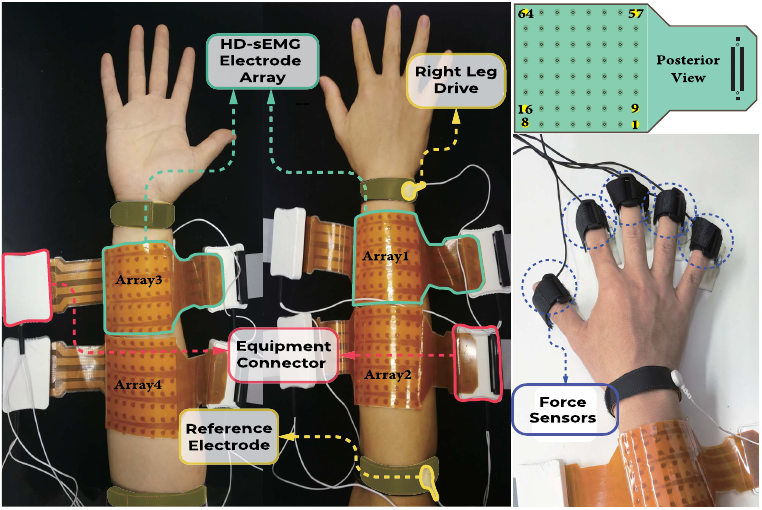

In particular, the first two arrays recorded the activity of the extensor muscle, whereas the remaining two arrays recorded the activity of the flexor muscle.

## 3. Decomposition

For the decomposition, let's focus on the 1 DoF dataset: for each subject, we have

- 2 recording sessions;
- 5 tasks (one per finger);
- 3 trials;
- 2 muscle;

resulting in 60 sEMG recordings (with 128 channels).

For instance, let's load the data of the first subject. Then, let's visualize the first 9 channels of the sEMG recorded in the first trial, for the index finger and for the extensor muscle.

Data loaded in 19.60 s


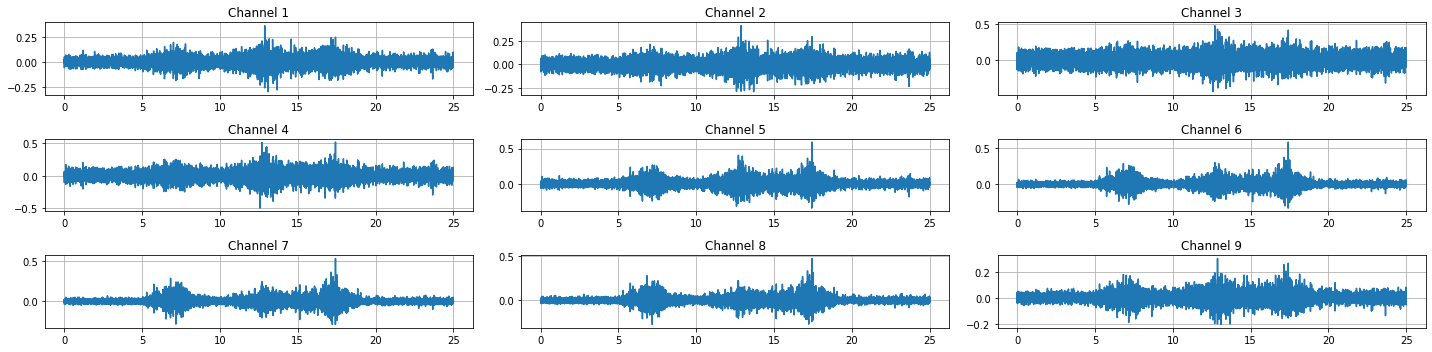

In [2]:
sub_emg = semg_bss.load_1dof(DATA_DIR, subject=1, session=1, verbose=True)

finger = 1
trial = 1
muscle = 1
emg = sub_emg[finger][trial][128 * (muscle - 1):128 * muscle]  # load record for given finger, sample and muscle

semg_bss.plot_signal(emg[:9], FS_EMG, n_cols=3, fig_size=(20, 5))

The first step is signal extension: since we have a convolutive mixture, we must extend the signal by adding R delayed replicas of the original recordings.

In [3]:
R = 4
emg_ext = semg_bss.extend_signal(emg, R)

print("Shape of the original signal:", emg.shape)
print("Shape of the extended signal:", emg_ext.shape)

Shape of the original signal: (128, 51200)
Shape of the extended signal: (640, 51200)


Then, the extended signal is whitened via eigenvalue decomposition.

In [4]:
emg_white, _ = semg_bss.whiten_signal(emg_ext)

test = np.cov(emg_white)
assert np.allclose(test, np.eye(test.shape[0]), atol=1e-4), "Whitening not precise enough."

Then, we apply FastICA to the whitened signal. We're using the deflation strategy with the log-cosh function.

FastICA done in 713.69 s


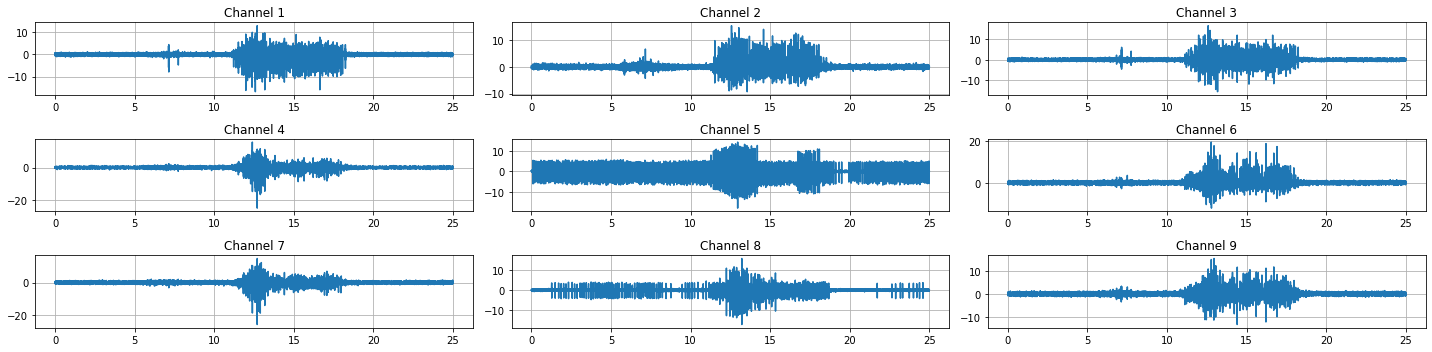

In [5]:
n_comp = 300
emg_sep, _ = semg_bss.fast_ica(emg_white, n_comp, prng=RNG, verbose=True)

semg_bss.plot_signal(emg_sep[:9], FS_EMG, n_cols=3, fig_size=(20, 5))

We obtain the actual spike trains using peak detection and $k$-means clustering with $k=2$ (to distinguish spikes from neural noise). Only the spike trains whose silhouette index is greater than 0.6 are retained.

Spike detected in 350.56 s
Valid spike trains after SIL-based filtering: 300


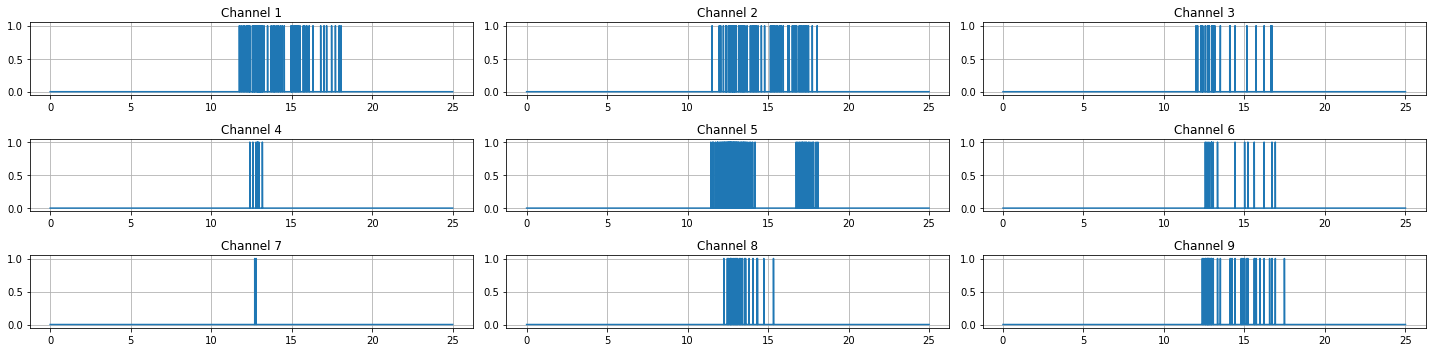

In [6]:
sil_th = 0.6
spike_train = semg_bss.spike_detection(emg_sep, sil_th, seed=SEED, verbose=True)
print("Valid spike trains after SIL-based filtering:", spike_train.shape[0])

semg_bss.plot_signal(spike_train[:9], FS_EMG, n_cols=3, fig_size=(20, 5))

The ICA algorithm may converge repetitively to the same MU or its delayed copies: if multiple spike trains share more than 50% synchronized firing events in a $\pm1$ ms window they're considered to be duplicate, and only the one with the highest silhouette score is retained.

N. components extracted: 143
Silhouette computed in 126.45 s
36 MUs extracted with an average silhouette score of 0.6661


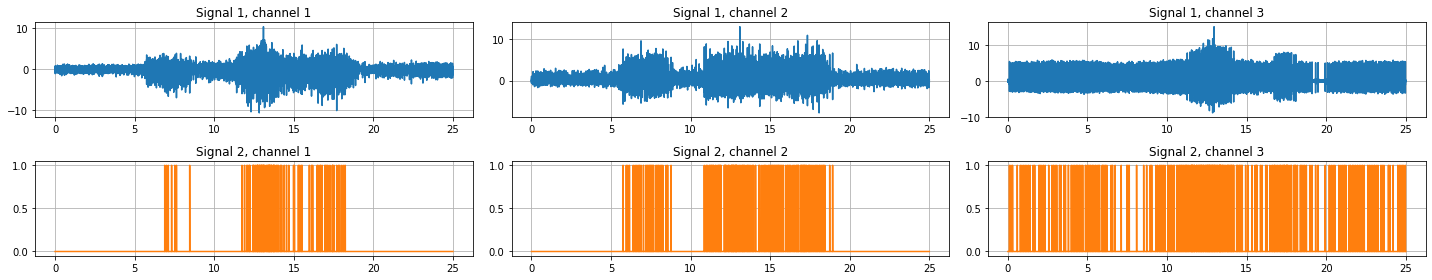

In [7]:
valid_index = semg_bss.replicas_removal(spike_train, emg_sep, FS_EMG)
spike_train = spike_train[valid_index]
emg_sep = emg_sep[valid_index]
print("N. components extracted:", spike_train.shape[0])
# Compute silhouette
sil = semg_bss.silhouette(emg_sep, FS_EMG, seed=SEED, verbose=True)
n_mu = sil[sil > sil_th].shape[0]
avg_sil = sil[sil > sil_th].mean()
print(f"{n_mu} MUs extracted with an average silhouette score of {avg_sil:.4f}")

semg_bss.plot_signals(emg_sep[:3], spike_train[:3], FS_EMG, n_cols=3, fig_size=(20, 4))

## 4. Results
The results of the decomposition of the **first subject**'s sEMG recordings are shown in the table.

|                |  Theirs |   Ours |
|----------------|--------:|-------:|
| Silhouette     |  0.7398 | 0.6733 |
| Correlation    |  0.7688 | 0.9429 |
| #MU (extensor) | 18.0667 |  60.00 |
| #MU (flexor)   |  4.1667 |  36.70 |

## 5. FFT analysis
Let's analyze the separated sEMG signals in the frequency domain.

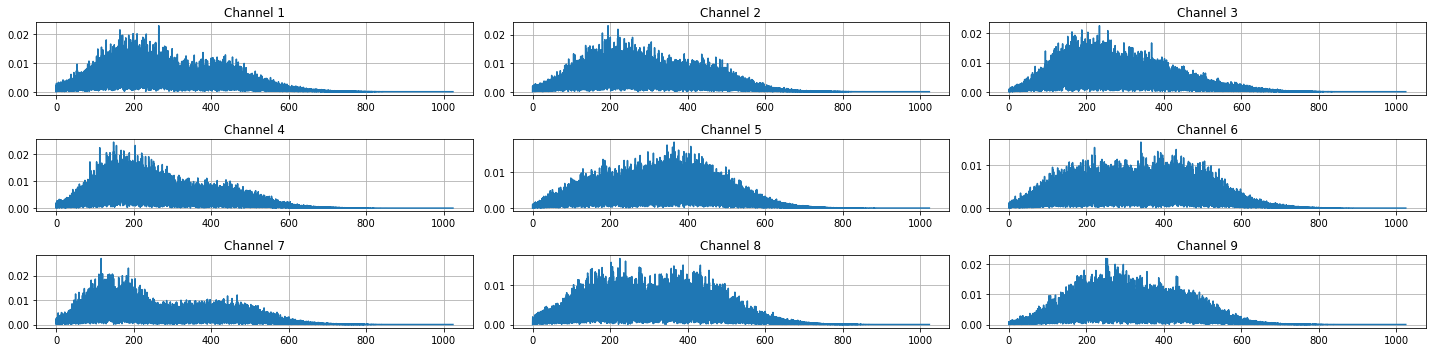

In [8]:
spectrum = semg_bss.signal_fft(emg_sep)

semg_bss.plot_signal(spectrum[:9], fs=emg_sep.shape[1] / FS_EMG, n_cols=3, fig_size=(20, 5))

Let's choose 50 Hz as minimum frequency for training/validation split.

Reserve a portion of the signal as the training set.

In [13]:
emg_sep = np.zeros(shape=(n_comp, emg.shape[1]), dtype=float)
train_size = 1000 // 50  # ms
print(f"Size of the training set: {train_size} ms")

start = 0
end = FS_EMG * train_size // 1000
# 2. Preprocessing (extension + whitening)
emg_ext = semg_bss.extend_signal(emg, R)
emg_white, white_mtx = semg_bss.whiten_signal(emg_ext[:, start:end])

# 3. FastICA
cur_emg_sep, sep_mtx = semg_bss.fast_ica(emg_white, n_comp, prng=RNG, verbose=True)
emg_sep[:, start:end] = cur_emg_sep

start = end
end = emg.shape[1]
# 2b. Preprocessing (extension + whitening) with precomputed whitening matrix
emg_mean = np.mean(emg_ext[:, start:end], axis=1, keepdims=True)
emg_center = emg_ext[:, start:end] - emg_mean
emg_white = white_mtx @ emg_center

# 3b. FastICA with precomputed weight matrix
cur_emg_sep = sep_mtx.T @ emg_white
emg_sep[:, start:end] = cur_emg_sep

Size of the training set: 20 ms
FastICA done in 39.17 s


Then, let's perform spike detection and replicas removal.

In [15]:
# 4. Spike detection
spike_train = semg_bss.spike_detection(emg_sep, sil_th, seed=SEED, verbose=True)

# 5. MU duplicates removal
valid_index = semg_bss.replicas_removal(spike_train, emg_sep, FS_EMG)
spike_train = spike_train[valid_index]
emg_sep = emg_sep[valid_index]
print("N. components extracted:", spike_train.shape[0])

# 6. Compute silhouette
sil = semg_bss.silhouette(emg_sep, FS_EMG, seed=SEED, verbose=True)
n_mu = sil[sil > sil_th].shape[0]
avg_sil = sil[sil > sil_th].mean()

print(f"{n_mu} MUs extracted with an average silhouette score of {avg_sil:.4f}")

emg_sep_valid = emg_sep[sil > sil_th]
spike_train_valid = spike_train[sil > sil_th]

Spike detected in 349.83 s
N. components extracted: 160
Silhouette computed in 119.74 s
55 MUs extracted with an average silhouette score of 0.6180


Let's plot the decomposed signal together with the spike trains.

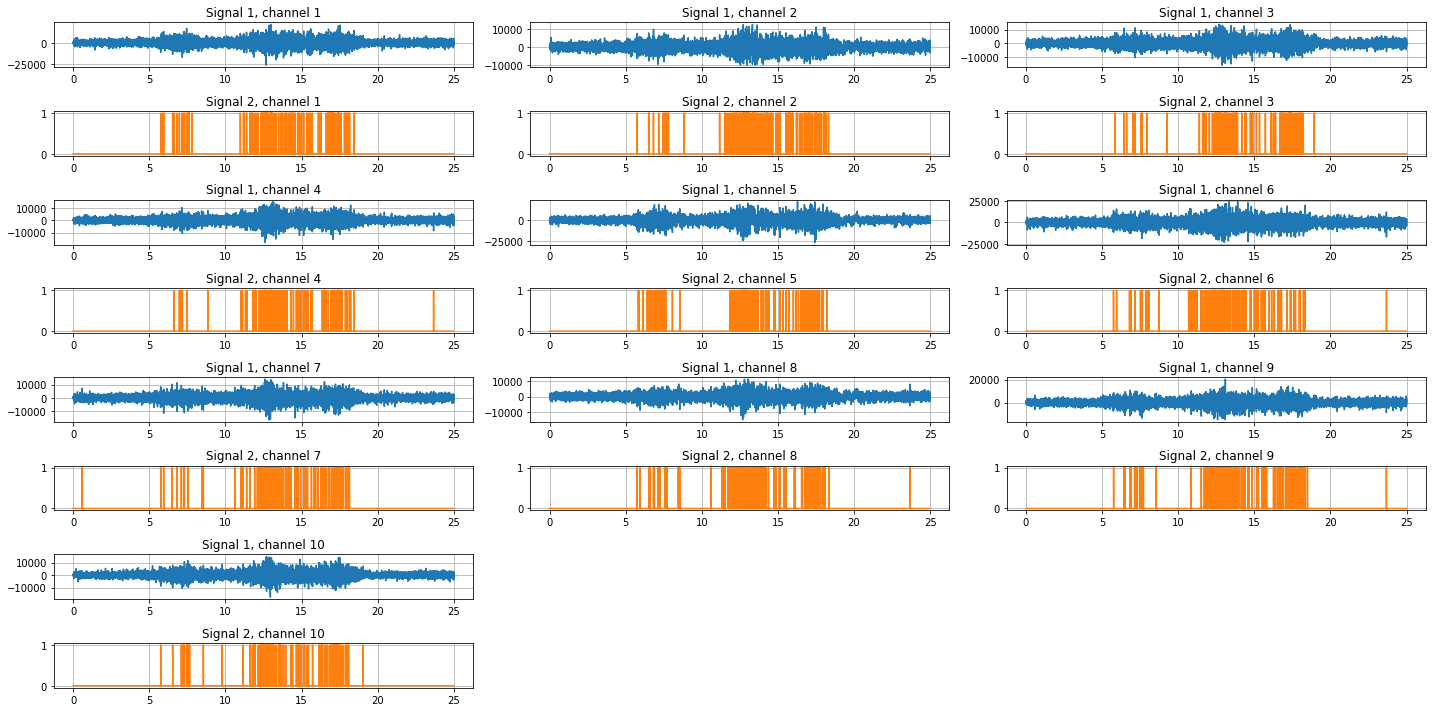

In [20]:
semg_bss.plot_signals(emg_sep_valid[:10], spike_train_valid[:10], FS_EMG, n_cols=3, fig_size=(20, 10))

In [6]:
R = 4
n_comp = 300
sil_th = 0.6
emg = sub_emg[2][trial][128 * (muscle - 1):128 * muscle]
emg_ext = semg_bss.extend_signal(emg, R)
emg_white, white_mtx = semg_bss.whiten_signal(emg_ext)
emg_sep, sep_mtx = semg_bss.fast_ica(emg_white, n_comp, prng=RNG, verbose=True)
spectrum = semg_bss.signal_fft(emg_sep)

semg_bss.plot_signal(spectrum[:9], fs=emg_sep.shape[1] / FS_EMG, n_cols=3, fig_size=(20, 5))

KeyError: 0